In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

In [2]:
from sklearn.preprocessing import MinMaxScaler
# Scatter matrix
from pandas.plotting import scatter_matrix

# MP2

## Ingesting the data

In [3]:
#The data is placed in an folder so we load the data through the folder with \
data1 = pd.read_excel("wine-data\winequality-red.xlsx", header=1)
data2 = pd.read_excel("wine-data\winequality-white.xlsx", header=1)

### Aggregating the data together into one data file - but first we add a column named type

In [4]:
#Adding the type
data1["type"] = "red"
data2["type"] = "white"

# Merge/concatenate - the ignore_index resets the index numbers
wine = pd.concat([data1, data2], ignore_index=True)

In [5]:
#Shows a random sample, to show that the data is mixed
wine.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
5175,7.4,0.280,0.36,14.60,0.048,35.0,161.0,0.99680,3.14,0.56,10.6,5,white
3392,7.4,0.350,0.31,17.95,0.062,42.0,187.0,1.00020,3.27,0.64,9.1,5,white
2745,9.1,0.270,0.32,1.10,0.031,15.0,151.0,0.99360,3.03,0.41,10.6,5,white
5545,6.0,0.300,0.33,2.10,0.042,31.0,127.0,0.98964,3.32,0.42,12.5,6,white
73,8.3,0.675,0.26,2.10,0.084,11.0,43.0,0.99760,3.31,0.53,9.2,4,red
4343,6.7,0.270,0.33,3.60,0.034,9.0,45.0,0.99144,3.08,0.40,10.5,6,white
5122,6.0,0.230,0.15,9.70,0.048,101.0,207.0,0.99571,3.05,0.30,9.1,5,white
5595,6.7,0.280,0.34,8.90,0.048,32.0,111.0,0.99455,3.25,0.54,11.0,7,white
4608,6.5,0.200,0.50,18.10,0.054,50.0,221.0,0.99941,2.94,0.64,8.8,6,white
6219,6.4,0.380,0.19,4.50,0.038,36.0,119.0,0.99151,3.07,0.42,11.2,6,white


## Cleaning the data

In [6]:
#We use shape to show the size of the dataset, through the number of observations and how many variables there are
wine.shape

(6497, 13)

In [7]:
#Finding missing values (null) - It shows how many of the different variables has null values
print(wine.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64


### Since there are no null values, we do not need to drop them

In [8]:
#Shows how many duplicated values there are. It compares all of the columns.
wine.duplicated().sum()

np.int64(1177)

### We therefore have 1177 duplicates

In [9]:
#This shows the first five duplicates.
duplicates = wine[wine.duplicated()]
print(duplicates.head())

    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4             7.4             0.700         0.00            1.90      0.076   
11            7.5             0.500         0.36            6.10      0.071   
27            7.9             0.430         0.21            1.60      0.106   
40            7.3             0.450         0.36            5.90      0.074   
65            7.2             0.725         0.05            4.65      0.086   

    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
4                  11.0                  34.0   0.9978  3.51       0.56   
11                 17.0                 102.0   0.9978  3.35       0.80   
27                 10.0                  37.0   0.9966  3.17       0.91   
40                 12.0                  87.0   0.9978  3.33       0.83   
65                  4.0                  11.0   0.9962  3.41       0.39   

    alcohol  quality type  
4       9.4        5  red  
11     10.5       

In [10]:
#Dropping the 1177 duplicates and resetting the index
wine.drop_duplicates(inplace=True, ignore_index=True)

### Checking for damaged values

In [11]:
#Negative values - 
(wine.drop(columns="type") < 0).sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [12]:
#pH value 7 or bigger for wine, as wine is acid and 7 is neutral - 
wine[(wine['pH']>7)].sum()

fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                   0
type                      0
dtype: object

## The outliers for the "accepted" wine values

In [13]:
def check_min_max(list, expected_range):
    report = []
    for col, (min_val, max_val) in expected_range.items():
        count = ((list[col] < min_val) | (list[col] > max_val)).sum()
        report.append({"column": col, "outliers": count})

    report_df = pd.DataFrame(report)
    print(report_df)

In [14]:
#Our expected ranges for red wine
expected_ranges_red = {
    "fixed acidity": (4.6, 15.9),
    "volatile acidity": (0.12, 1.58),
    "citric acid": (0.0, 1.0),
    "residual sugar": (0.9, 15.5),
    "chlorides": (0.012, 0.611),
    "free sulfur dioxide": (1, 72),
    "total sulfur dioxide": (6, 289),
    "density": (0.99007, 1.00369),
    "pH": (2.74, 4.01),
    "sulphates": (0.33, 2.0),
    "alcohol": (8.4, 14.9),
    "quality": (3, 8)
}
red_wine = wine[wine["type"] == "red"]

check_min_max(red_wine, expected_ranges_red)

                  column  outliers
0          fixed acidity         0
1       volatile acidity         0
2            citric acid         0
3         residual sugar         0
4              chlorides         0
5    free sulfur dioxide         0
6   total sulfur dioxide         0
7                density         0
8                     pH         0
9              sulphates         0
10               alcohol         0
11               quality         0


In [15]:
#Our expected ranges for white wine
expected_ranges_white = {
    "fixed acidity": (3.8, 14.2),
    "volatile acidity": (0.08, 1.10),
    "citric acid": (0.0, 1.66),
    "residual sugar": (0.6, 65.8),
    "chlorides": (0.009, 0.346),
    "free sulfur dioxide": (2, 289),
    "total sulfur dioxide": (9, 440),
    "density": (0.98711, 1.03898),
    "pH": (2.72, 3.82),
    "sulphates": (0.22, 1.08),
    "alcohol": (8.0, 14.2),
    "quality": (3, 9)
}

#Right now we are only checking for the values of white wine, so we need to filter on the type of wine
white_wine = wine[wine["type"] == "white"]

check_min_max(white_wine, expected_ranges_white)

                  column  outliers
0          fixed acidity         0
1       volatile acidity         0
2            citric acid         0
3         residual sugar         0
4              chlorides         0
5    free sulfur dioxide         0
6   total sulfur dioxide         0
7                density         0
8                     pH         0
9              sulphates         0
10               alcohol         0
11               quality         0


In [16]:
#Shows the count, mean std fopr the collective winelist
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000
mean,7.215179,0.344130,0.318494,5.048477,0.056690,30.036654,114.109023,0.994535,3.224664,0.533357,10.549241,5.795677
std,1.319671,0.168248,0.147157,4.500180,0.036863,17.805045,56.774223,0.002966,0.160379,0.149743,1.185933,0.879772
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,74.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994650,3.210000,0.510000,10.400000,6.000000
75%,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,153.250000,0.996770,3.330000,0.600000,11.400000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [17]:
#Description of red wine - the list is made previously: red_wine = wine[wine["type"] == "red"]
red_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [18]:
#Description of white wine - the list is made previously: white_wine = wine[wine["type"] == "white"]
white_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000
mean,6.839346,0.280538,0.334332,5.914819,0.045905,34.889169,137.193512,0.993790,3.195458,0.490351,10.589358,5.854835
std,0.866860,0.103437,0.122446,4.861646,0.023103,17.210021,43.129065,0.002905,0.151546,0.113523,1.217076,0.890683
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.600000,0.035000,23.000000,106.000000,0.991620,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,4.700000,0.042000,33.000000,133.000000,0.993500,3.180000,0.480000,10.400000,6.000000
75%,7.300000,0.330000,0.390000,8.900000,0.050000,45.000000,166.000000,0.995710,3.290000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [19]:
#The shape of red wine after cleaning
red_wine.shape

(1359, 13)

In [20]:
#The shape of white wine after cleaning
white_wine.shape

(3961, 13)

## Endcoding

In [21]:
#Pre Label encoding - Categorical Encoding
wine.dtypes

wine["type"] = wine["type"].astype("category")

wine.dtypes

cat_data = wine.select_dtypes('category').columns

cat_data

# print these columns only
wine[cat_data].sample(10)

categorical_data = wine[cat_data]
categorical_data

,type
0,red
1,red
2,red
3,red
4,red
...,...
5315,white
5316,white
5317,white
5318,white


In [22]:
# Label Endcoding which is converting the text values into numerical values

cats = categorical_data["type"].unique()
cats

categorical_data = wine[["type"]].copy()
categorical_data["type_encoded"] = categorical_data["type"].cat.codes
categorical_data.sample(10)

,type,type_encoded
4321,white,1
4011,white,1
1421,white,1
1341,red,0
3247,white,1
3617,white,1
748,red,0
5312,white,1
2271,white,1
3578,white,1


In [23]:
# adding the encoded column to the original dataframe and dropping the text column
# White wine = 1 and red wine = 0
wine["type_encoded"] = wine["type"].cat.codes
wine_transformed = wine.drop(["type"], axis=1)

print(wine_transformed)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.66         0.00             1.8      0.075   
...             ...               ...          ...             ...        ...   
5315            6.2              0.21         0.29             1.6      0.039   
5316            6.6              0.32         0.36             8.0      0.047   
5317            6.5              0.24         0.19             1.2      0.041   
5318            5.5              0.29         0.30             1.1      0.022   
5319            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  

### Normalization

In [24]:
# Sørg for, at kolonnen "type_encoded" er til stede i red_wine og white_wine
red_wine["type_encoded"] = wine[wine["type"] == "red"]["type_encoded"]
white_wine["type_encoded"] = wine[wine["type"] == "white"]["type_encoded"]

# Fjern kolonnen "type" fra red_wine og white_wine
red_wine_transformed = red_wine.drop(columns=["type"]).copy()
white_wine_transformed = white_wine.drop(columns=["type"]).copy()

# normalization - Scaling the data to a range of 0 to 1
scaler = MinMaxScaler()

# Fit og transformér hele datasættet
all_wine_norm = scaler.fit_transform(wine_transformed)

# Brug transform() for at genbruge skalaen på red_wine og white_wine
red_wine_norm = scaler.transform(red_wine_transformed)
white_wine_norm = scaler.transform(white_wine_transformed)

# Konverter tilbage til DataFrame for at bevare kolonnenavne
all_wine_norm = pd.DataFrame(all_wine_norm, columns=wine_transformed.columns)
red_wine_norm = pd.DataFrame(red_wine_norm, columns=red_wine_transformed.columns)
white_wine_norm = pd.DataFrame(white_wine_norm, columns=white_wine_transformed.columns)

# Udskriv resultater
print(all_wine_norm.head())
print(red_wine_norm.head())
print(white_wine_norm.head())


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.297521          0.413333     0.000000        0.019939   0.111296   
1       0.330579          0.533333     0.000000        0.030675   0.147841   
2       0.330579          0.453333     0.024096        0.026074   0.137874   
3       0.611570          0.133333     0.337349        0.019939   0.109635   
4       0.297521          0.386667     0.000000        0.018405   0.109635   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.034722              0.064516  0.206092  0.612403   0.191011   
1             0.083333              0.140553  0.186813  0.372093   0.258427   
2             0.048611              0.110599  0.190669  0.418605   0.241573   
3             0.055556              0.124424  0.209948  0.341085   0.202247   
4             0.041667              0.078341  0.206092  0.612403   0.191011   

    alcohol   quality  type_encoded  
0  0.202899  0.333

C:\Users\rfwma\AppData\Local\Temp\ipykernel_24424\4176646370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_wine["type_encoded"] = wine[wine["type"] == "red"]["type_encoded"]
C:\Users\rfwma\AppData\Local\Temp\ipykernel_24424\4176646370.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_wine["type_encoded"] = wine[wine["type"] == "white"]["type_encoded"]


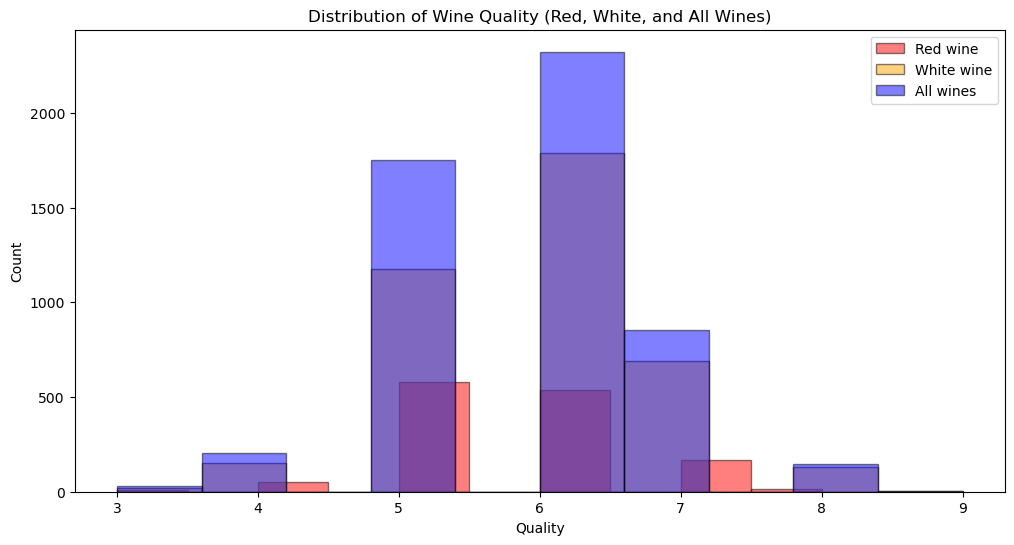

In [25]:
# normal distrubted histogram -> bellcurve

# Histogram af kvalitet for rød, hvid og alle vine
plt.figure(figsize=(12, 6))

# Histogram for rødvin
plt.hist(wine[wine["type"] == "red"]["quality"], bins=10, alpha=0.5, label="Red wine", color="red", edgecolor="black")

# Histogram for hvidvin
plt.hist(wine[wine["type"] == "white"]["quality"], bins=10, alpha=0.5, label="White wine", color="orange", edgecolor="black")

# Histogram for alle vine
plt.hist(wine["quality"], bins=10, alpha=0.5, label="All wines", color="blue", edgecolor="black")

# Tilføj labels og titel
plt.xlabel("Quality")
plt.ylabel("Count")
plt.title("Distribution of Wine Quality (Red, White, and All Wines)")
plt.legend()
plt.show()

## Exploration

### Correlation

In [26]:
# Selects the data that are only numbers
num_data = wine.select_dtypes(include=["number"]).columns.tolist()
num_data

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality',
 'type_encoded']

array([[<Axes: xlabel='fixed acidity', ylabel='fixed acidity'>,
        <Axes: xlabel='volatile acidity', ylabel='fixed acidity'>,
        <Axes: xlabel='citric acid', ylabel='fixed acidity'>,
        <Axes: xlabel='residual sugar', ylabel='fixed acidity'>,
        <Axes: xlabel='chlorides', ylabel='fixed acidity'>,
        <Axes: xlabel='free sulfur dioxide', ylabel='fixed acidity'>,
        <Axes: xlabel='total sulfur dioxide', ylabel='fixed acidity'>,
        <Axes: xlabel='density', ylabel='fixed acidity'>,
        <Axes: xlabel='pH', ylabel='fixed acidity'>,
        <Axes: xlabel='sulphates', ylabel='fixed acidity'>,
        <Axes: xlabel='alcohol', ylabel='fixed acidity'>,
        <Axes: xlabel='quality', ylabel='fixed acidity'>,
        <Axes: xlabel='type_encoded', ylabel='fixed acidity'>],
       [<Axes: xlabel='fixed acidity', ylabel='volatile acidity'>,
        <Axes: xlabel='volatile acidity', ylabel='volatile acidity'>,
        <Axes: xlabel='citric acid', ylabel='volatile

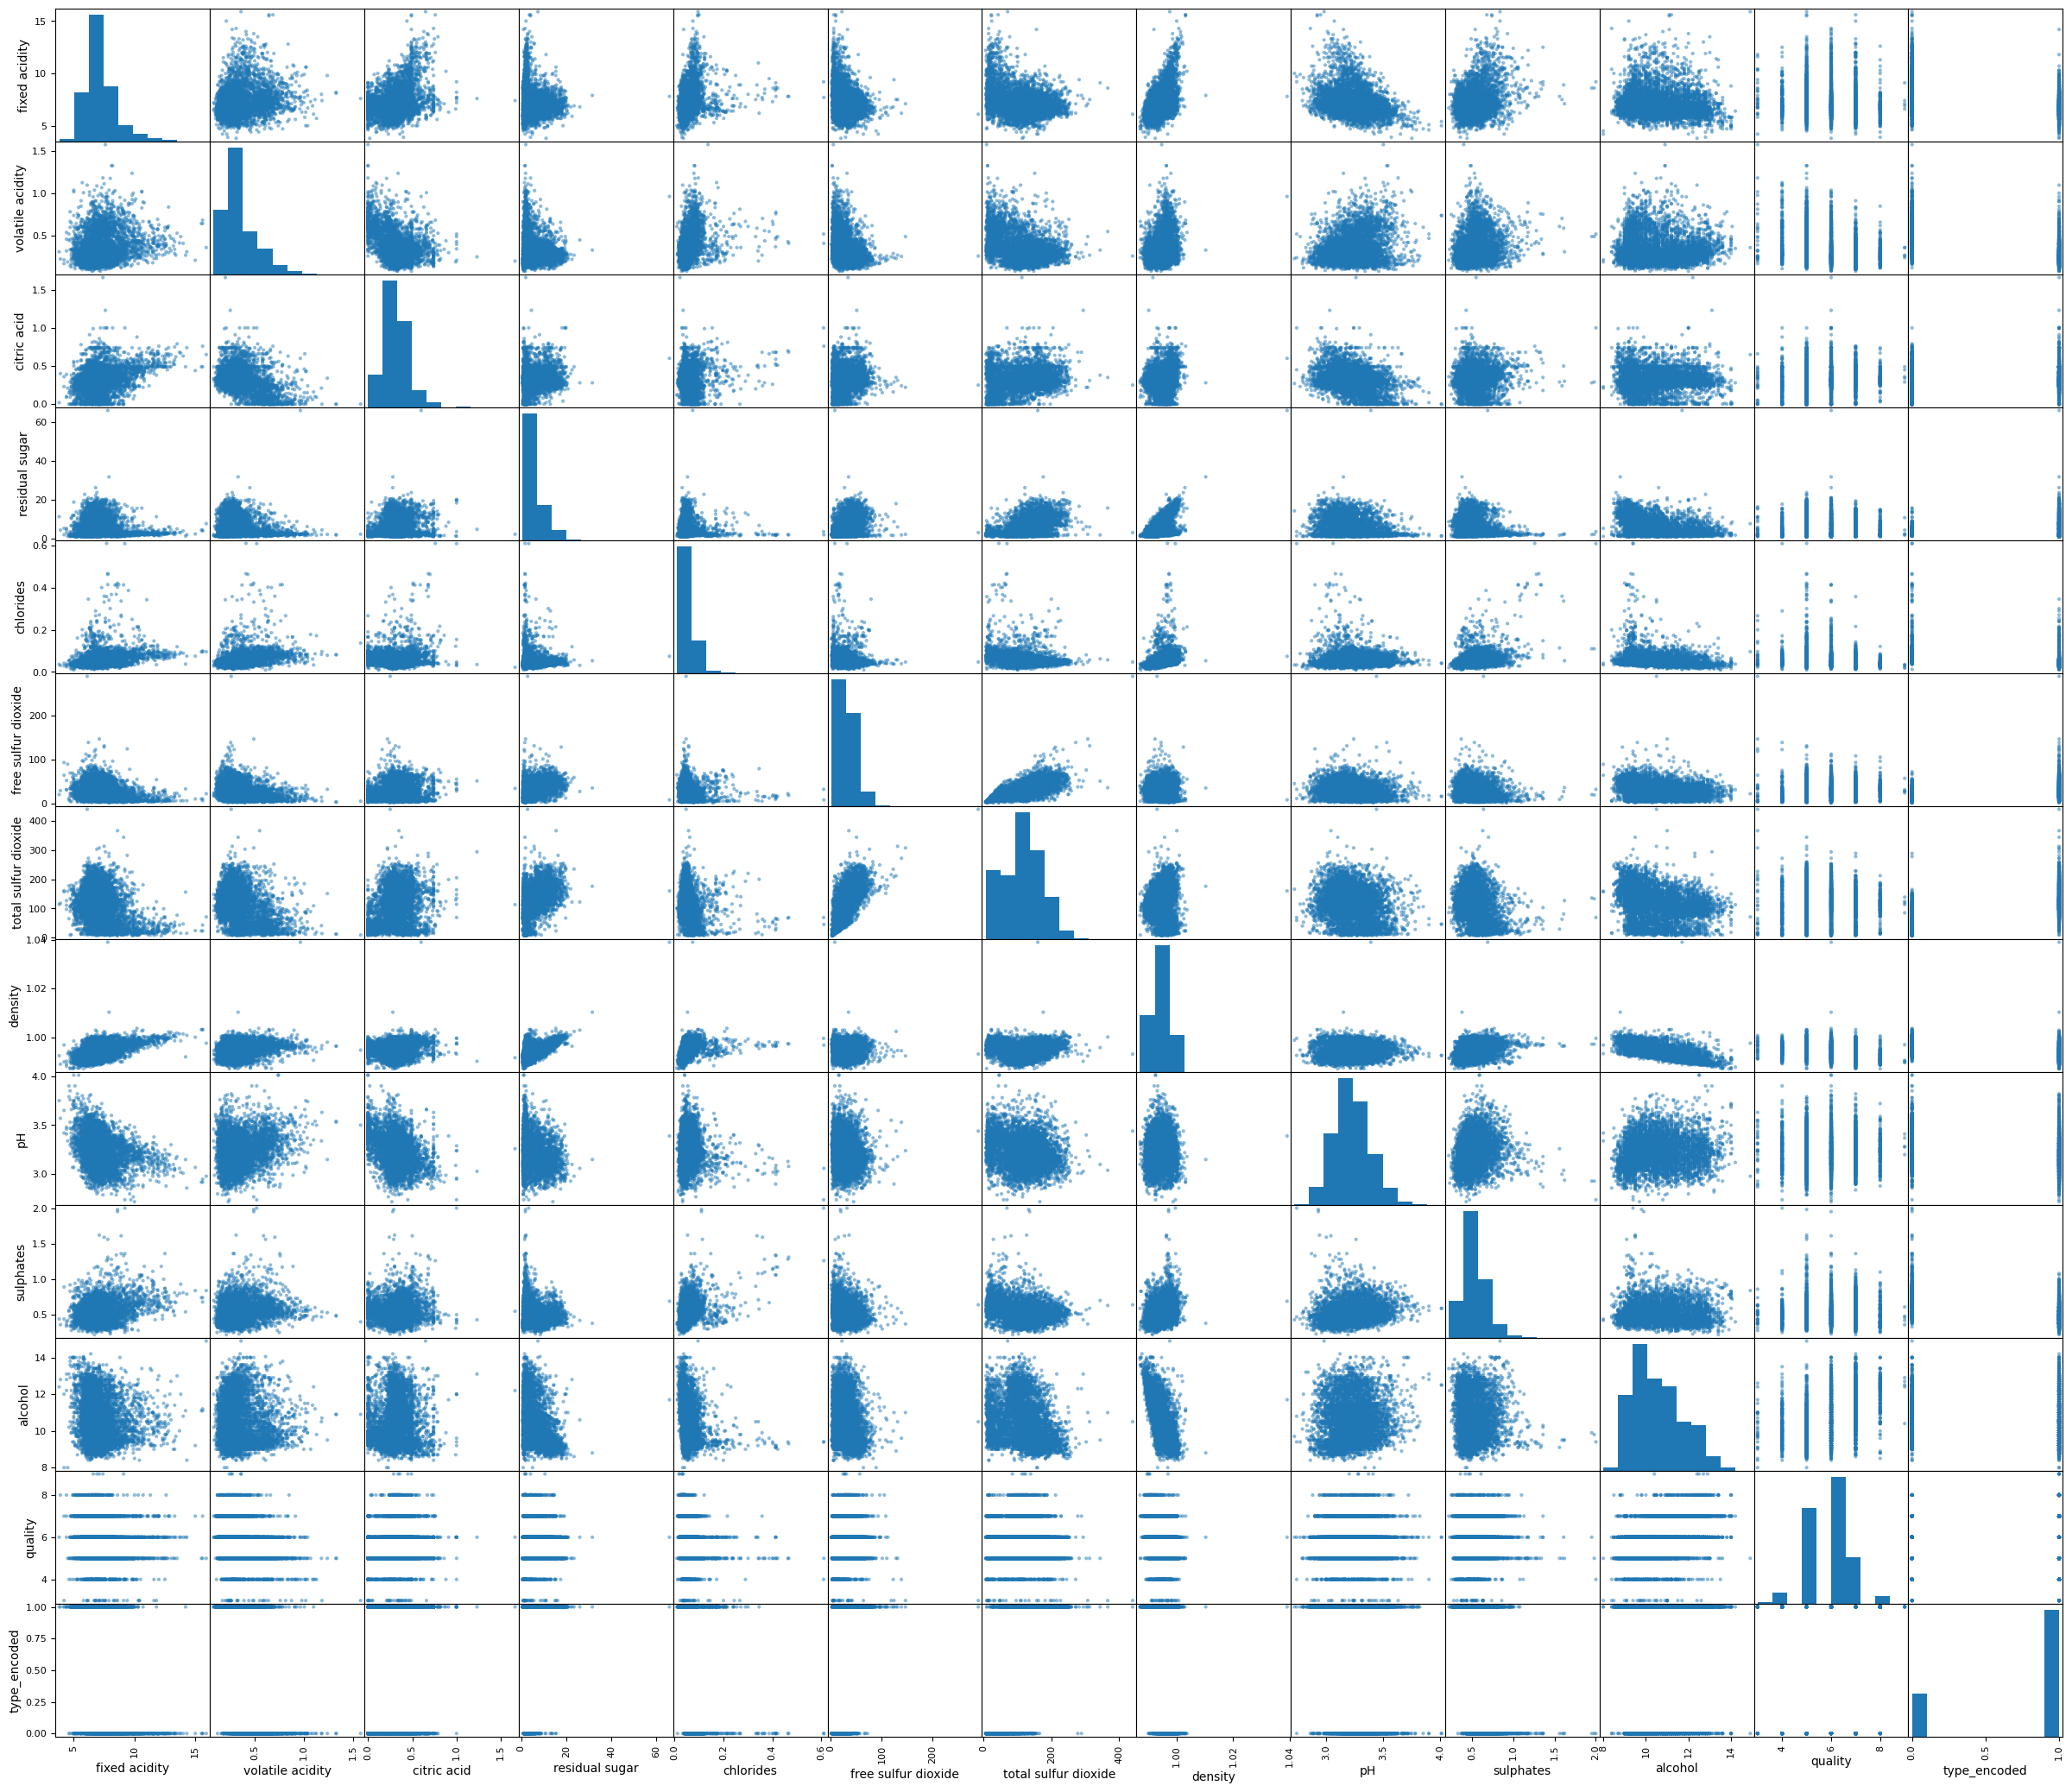

In [27]:
# Shows a scatter plot matrix
scatter_matrix(wine[num_data], figsize=(30,26))

In [28]:
# Calculates the correlation values
post_norm_corr_all = all_wine_norm.corr(method='pearson', numeric_only=True)
# Prints the correlation coeficients in a table for all the values
post_norm_corr_all

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_encoded
fixed acidity,1.000000,0.214752,0.330328,-0.104439,0.288918,-0.281590,-0.327471,0.478180,-0.271182,0.304844,-0.102573,-0.080092,-0.486253
volatile acidity,0.214752,1.000000,-0.384192,-0.163696,0.367626,-0.349039,-0.400716,0.308452,0.246687,0.227772,-0.065411,-0.265205,-0.645335
citric acid,0.330328,-0.384192,1.000000,0.146189,0.055199,0.130849,0.194835,0.094758,-0.344735,0.059183,-0.005496,0.097954,0.183759
residual sugar,-0.104439,-0.163696,0.146189,1.000000,-0.123094,0.398717,0.487519,0.520930,-0.234522,-0.174717,-0.305242,-0.056830,0.328695
chlorides,0.288918,0.367626,0.055199,-0.123094,1.000000,-0.186615,-0.269817,0.371867,0.025823,0.405051,-0.269601,-0.202137,-0.499517
free sulfur dioxide,-0.281590,-0.349039,0.130849,0.398717,-0.186615,1.000000,0.720488,0.006166,-0.141747,-0.198244,-0.170012,0.054002,0.465326
total sulfur dioxide,-0.327471,-0.400716,0.194835,0.487519,-0.269817,0.720488,1.000000,0.006711,-0.222956,-0.275836,-0.249004,-0.050296,0.694229
density,0.478180,0.308452,0.094758,0.520930,0.371867,0.006166,0.006711,1.000000,0.034273,0.282690,-0.667811,-0.326434,-0.429377
pH,-0.271182,0.246687,-0.344735,-0.234522,0.025823,-0.141747,-0.222956,0.034273,1.000000,0.168150,0.097314,0.039733,-0.310919
sulphates,0.304844,0.227772,0.059183,-0.174717,0.405051,-0.198244,-0.275836,0.282690,0.168150,1.000000,-0.017232,0.041884,-0.490364


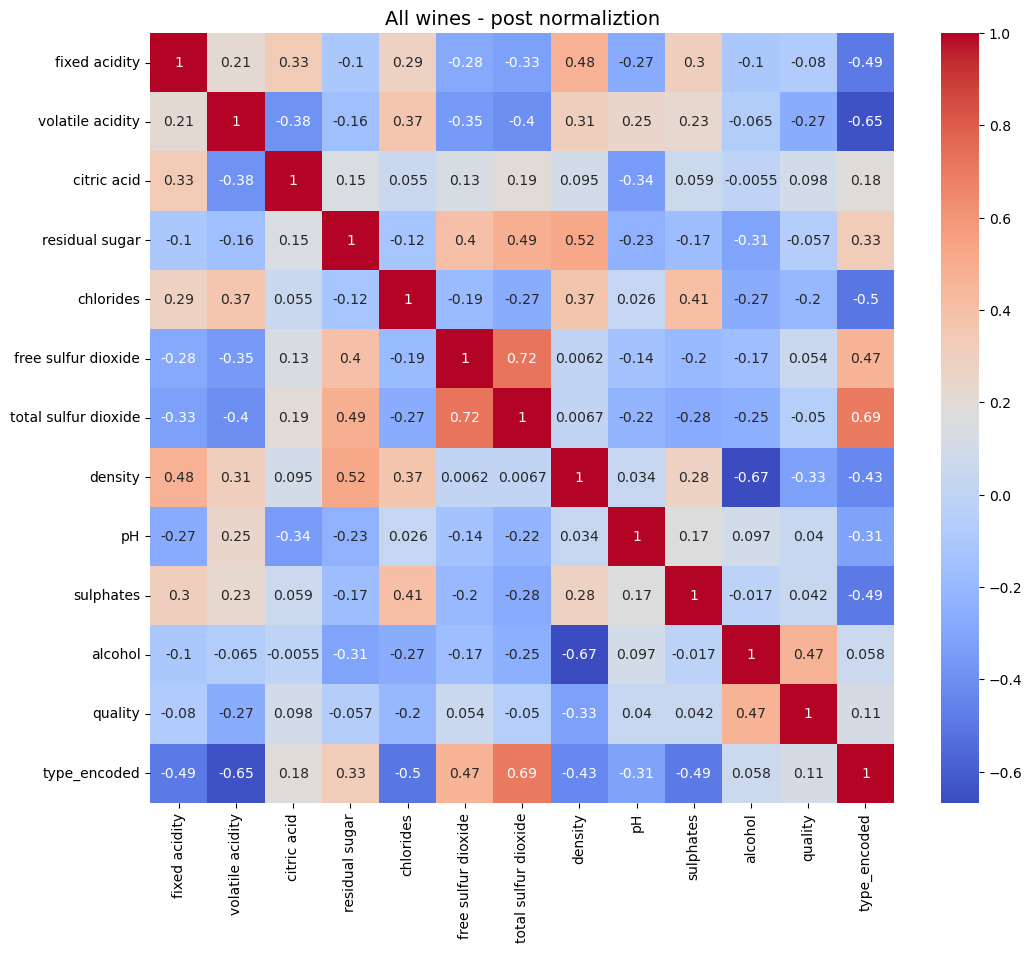

In [29]:
#heatmap with normalized data
# Heatmap
plt.figure(figsize=(12, 10))
sb.heatmap(post_norm_corr_all, annot=True, cmap='coolwarm')
plt.title("All wines - post normaliztion", fontsize=14)
plt.show()

## Correlations for all wines seems to low everywhere,so it warrents that we check red and white for them selves

In [30]:
# Calculates the correlation values
post_norm_corr_red = red_wine_norm.corr(method='pearson', numeric_only=True)
# Prints the correlation coeficients in a table for all the values
post_norm_corr_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_encoded
fixed acidity,1.000000,-0.255124,0.667437,0.111025,0.085886,-0.140580,-0.103777,0.670195,-0.686685,0.190269,-0.061596,0.119024,NaN
volatile acidity,-0.255124,1.000000,-0.551248,-0.002449,0.055154,-0.020945,0.071701,0.023943,0.247111,-0.256948,-0.197812,-0.395214,NaN
citric acid,0.667437,-0.551248,1.000000,0.143892,0.210195,-0.048004,0.047358,0.357962,-0.550310,0.326062,0.105108,0.228057,NaN
residual sugar,0.111025,-0.002449,0.143892,1.000000,0.026656,0.160527,0.201038,0.324522,-0.083143,-0.011837,0.063281,0.013640,NaN
chlorides,0.085886,0.055154,0.210195,0.026656,1.000000,0.000749,0.045773,0.193592,-0.270893,0.394557,-0.223824,-0.130988,NaN
free sulfur dioxide,-0.140580,-0.020945,-0.048004,0.160527,0.000749,1.000000,0.667246,-0.018071,0.056631,0.054126,-0.080125,-0.050463,NaN
total sulfur dioxide,-0.103777,0.071701,0.047358,0.201038,0.045773,0.667246,1.000000,0.078141,-0.079257,0.035291,-0.217829,-0.177855,NaN
density,0.670195,0.023943,0.357962,0.324522,0.193592,-0.018071,0.078141,1.000000,-0.355617,0.146036,-0.504995,-0.184252,NaN
pH,-0.686685,0.247111,-0.550310,-0.083143,-0.270893,0.056631,-0.079257,-0.355617,1.000000,-0.214134,0.213418,-0.055245,NaN
sulphates,0.190269,-0.256948,0.326062,-0.011837,0.394557,0.054126,0.035291,0.146036,-0.214134,1.000000,0.091621,0.248835,NaN


In [31]:
# Calculates the correlation values
post_norm_corr_white = white_wine_norm.corr(method='pearson', numeric_only=True)
# Prints the correlation coeficients in a table for all the values
post_norm_corr_white

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_encoded
fixed acidity,1.000000,-0.019214,0.298959,0.083620,0.024036,-0.058396,0.082425,0.266091,-0.431274,-0.017453,-0.110788,-0.124636,NaN
volatile acidity,-0.019214,1.000000,-0.163228,0.098340,0.086287,-0.102471,0.102315,0.060603,-0.046954,-0.021150,0.046815,-0.190678,NaN
citric acid,0.298959,-0.163228,1.000000,0.106269,0.132590,0.091681,0.122845,0.160076,-0.183015,0.049442,-0.076514,0.007065,NaN
residual sugar,0.083620,0.098340,0.106269,1.000000,0.076091,0.306835,0.409583,0.820498,-0.165997,-0.020503,-0.398167,-0.117339,NaN
chlorides,0.024036,0.086287,0.132590,0.076091,1.000000,0.101272,0.191145,0.253088,-0.090573,0.017871,-0.356928,-0.217739,NaN
free sulfur dioxide,-0.058396,-0.102471,0.091681,0.306835,0.101272,1.000000,0.619437,0.294638,-0.007750,0.037932,-0.251768,0.010507,NaN
total sulfur dioxide,0.082425,0.102315,0.122845,0.409583,0.191145,0.619437,1.000000,0.536868,0.008239,0.136544,-0.446643,-0.183356,NaN
density,0.266091,0.060603,0.160076,0.820498,0.253088,0.294638,0.536868,1.000000,-0.063734,0.082048,-0.760162,-0.337805,NaN
pH,-0.431274,-0.046954,-0.183015,-0.165997,-0.090573,-0.007750,0.008239,-0.063734,1.000000,0.142353,0.093095,0.123829,NaN
sulphates,-0.017453,-0.021150,0.049442,-0.020503,0.017871,0.037932,0.136544,0.082048,0.142353,1.000000,-0.022850,0.053200,NaN


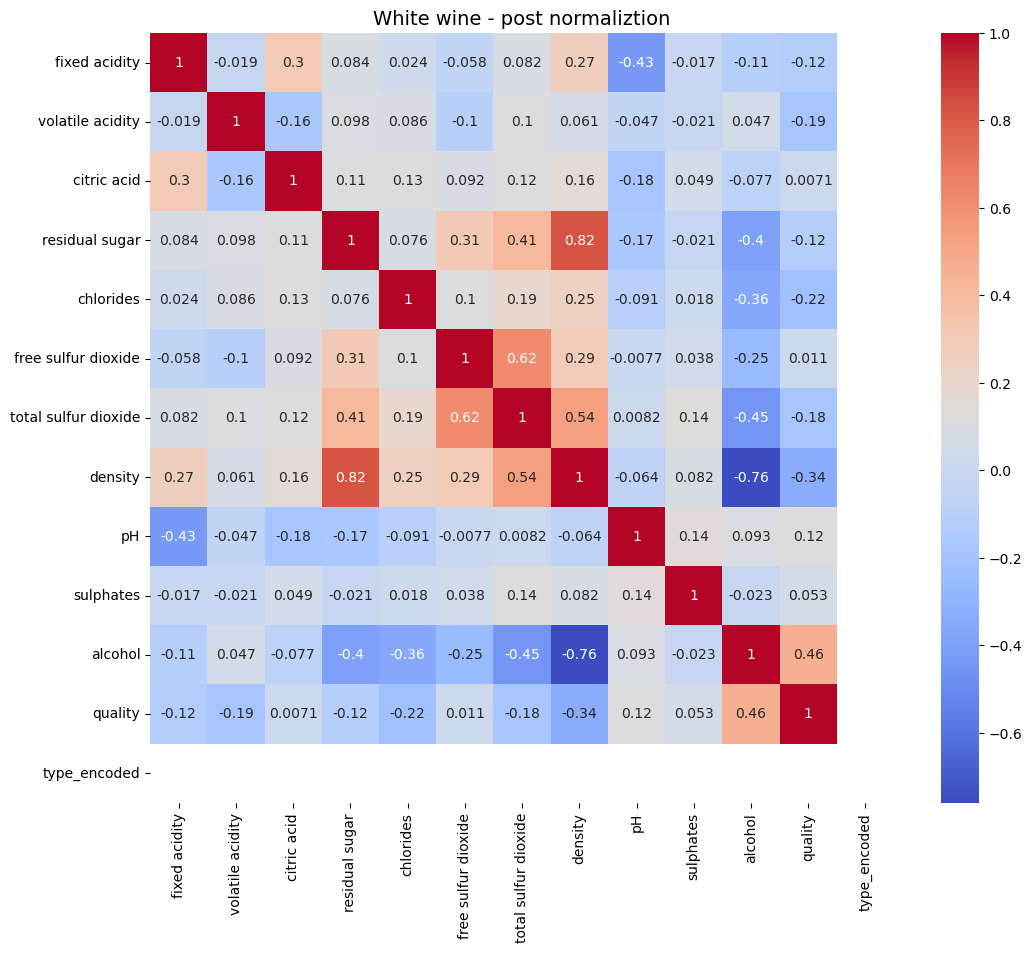

In [32]:
# Heatmap
plt.figure(figsize=(12, 10))
sb.heatmap(post_norm_corr_white, annot=True, cmap='coolwarm')
plt.title("White wine - post normaliztion", fontsize=14)

plt.show()

## The correlations for white wine:
it is high for:  
    1: density and residual sugar 
    2: density and alcohol

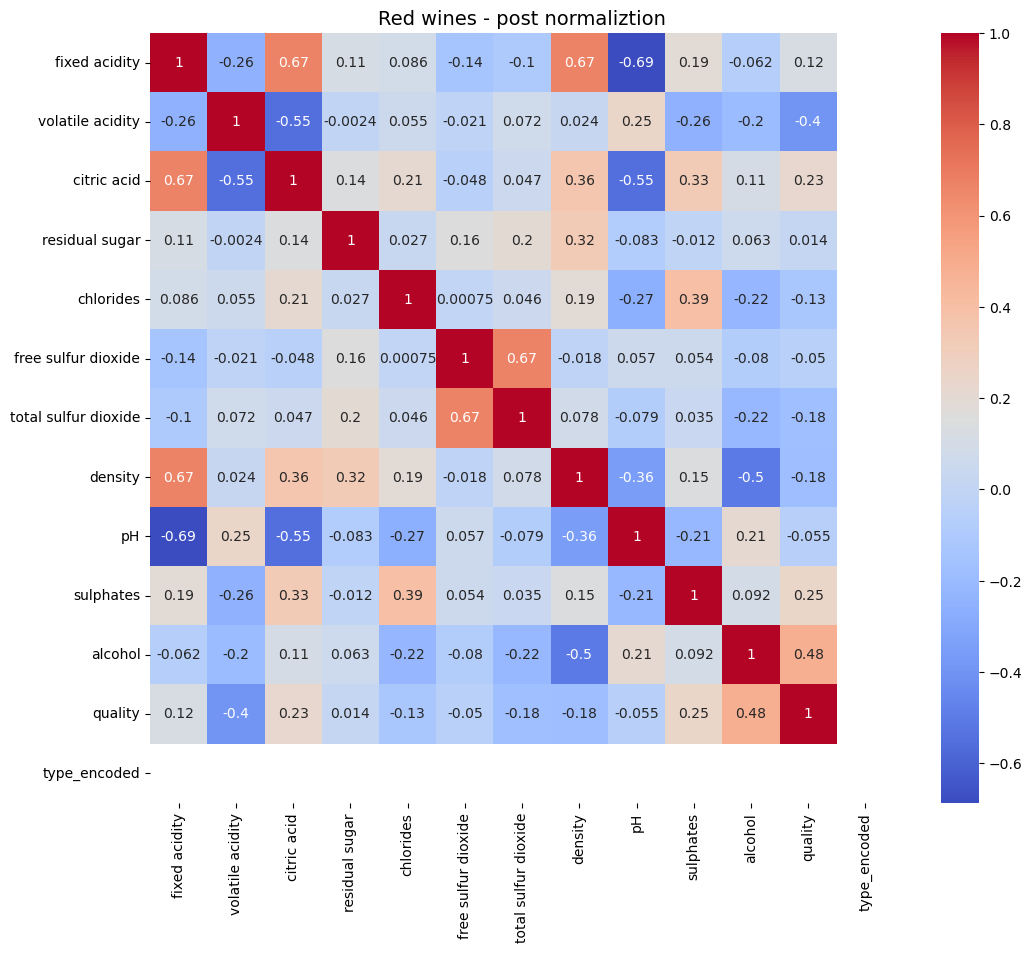

In [33]:
# Heatmap
plt.figure(figsize=(12, 10))
sb.heatmap(post_norm_corr_red, annot=True, cmap='coolwarm')
plt.title("Red wines - post normaliztion", fontsize=14)

plt.show()

## The correlations for red wine:
it is high for:
1. fixed acidity and Ph
2. fixed acidity and density

low for :
1. pH and citric acid
2. alcohol and density


## Warrents futher investigation for correlations

1. we want to see why residual sugar and alcohol compared to density doesn't correlate the same for red and white wine
2. we want to see why acids doesn't have a higher correlations with pH

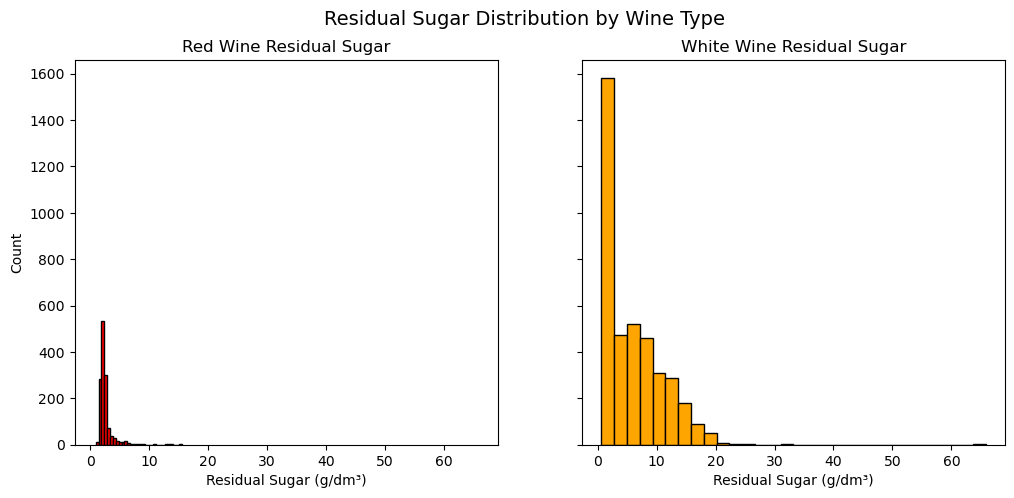

In [34]:
# Residual sugar histograms for red and white wines
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True, sharex=True)

axes[0].hist(
    wine[wine["type_encoded"]==0]["residual sugar"],
    bins=30, color="red", edgecolor="black"
)
axes[0].set_title("Red Wine Residual Sugar")
axes[0].set_xlabel("Residual Sugar (g/dm³)")
axes[0].set_ylabel("Count")

axes[1].hist(
    wine[wine["type_encoded"]==1]["residual sugar"],
    bins=30, color="orange", edgecolor="black"
)
axes[1].set_title("White Wine Residual Sugar")
axes[1].set_xlabel("Residual Sugar (g/dm³)")

plt.suptitle("Residual Sugar Distribution by Wine Type", fontsize=14)
plt.show()



## Findings

We can see that there is a lot more residual sugar in white wines. Therefor it affects the density a lot more than in red wines because the amount of sugar is much larger, so it has a higher impact on the density. That is also why we also see a lower correlation between sugar and density in red wines.

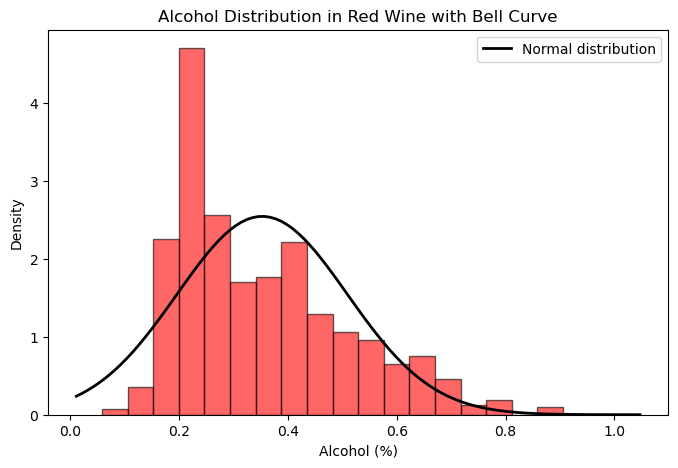

In [35]:
from scipy.stats import norm

# Select red wine alcohol column
red_alcohol = red_wine_norm["alcohol"]

# Calculate mean and std for normal curve
mu, sigma = red_alcohol.mean(), red_alcohol.std()

# Plot histogram
plt.figure(figsize=(8,5))
count, bins, ignored = plt.hist(red_alcohol, bins=20, density=True,
                                color="red", edgecolor="black", alpha=0.6)

# Plot bell curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, "k", linewidth=2, label="Normal distribution")

plt.title("Alcohol Distribution in Red Wine with Bell Curve")
plt.xlabel("Alcohol (%)")
plt.ylabel("Density")
plt.legend()
plt.show()



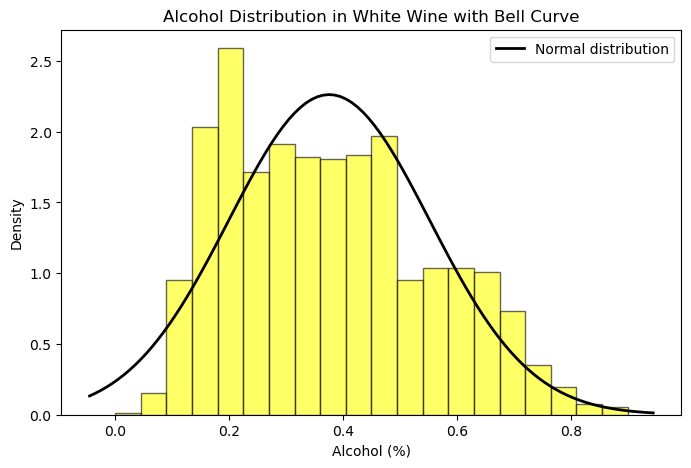

In [36]:
# Select white wine alcohol column
white_alcohol = white_wine_norm["alcohol"]

# Calculate mean and std for normal curve
mu, sigma = white_alcohol.mean(), white_alcohol.std()

# Plot histogram
plt.figure(figsize=(8,5))
count, bins, ignored = plt.hist(white_alcohol, bins=20, density=True,
                                color="yellow", edgecolor="black", alpha=0.6)

# Plot bell curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, "k", linewidth=2, label="Normal distribution")

plt.title("Alcohol Distribution in White Wine with Bell Curve")
plt.xlabel("Alcohol (%)")
plt.ylabel("Density")
plt.legend()
plt.show()


## Findings

We know that alcohol have a correlation with density since alcohol is less dense than water, which is what most wines is primarily made of.

The alcohol in red wine doesn't have a very good normal distribution so we expect that any correlation between alcohol and density for red wines will not be very high.

We can see that white wine has a better normal distribution for their alcohol. Therefor we expect that white wine has a better correlation between alcohol and density since its data is more normalized.

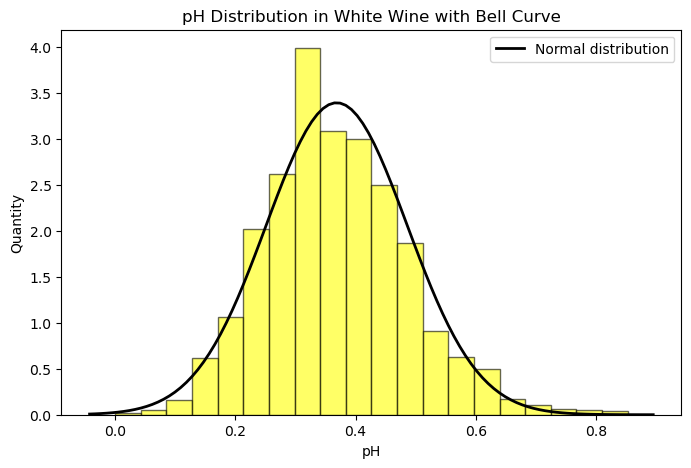

In [37]:
# Select white wine pH column
white_ph = white_wine_norm["pH"]

# Calculate mean and std for normal curve
mu, sigma = white_ph.mean(), white_ph.std()

# Plot histogram
plt.figure(figsize=(8,5))
count, bins, ignored = plt.hist(white_ph, bins=20, density=True,
                                color="yellow", edgecolor="black", alpha=0.6)

# Plot bell curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, "k", linewidth=2, label="Normal distribution")

plt.title("pH Distribution in White Wine with Bell Curve")
plt.xlabel("pH")
plt.ylabel("Quantity")
plt.legend()
plt.show()

In [64]:
print(f"Mode: {white_ph.mode()}")
print(f"Mean: {white_ph.mean()}")

Mode: 0    0.341085
Name: pH, dtype: float64
Mean: 0.36857226172233515


## Findings in relation to the bell curve for pH value in white wine
There is a bit of positive scewing as is shown on the figure above, which means there are larger portion of the dataset with a lower pH value than the mean. The skewing can also be expolated by comparing the mean and the mode

The mode for normalized pH value in white wine is 0.341, but the mean is 0.368, which means it is positively skewed.

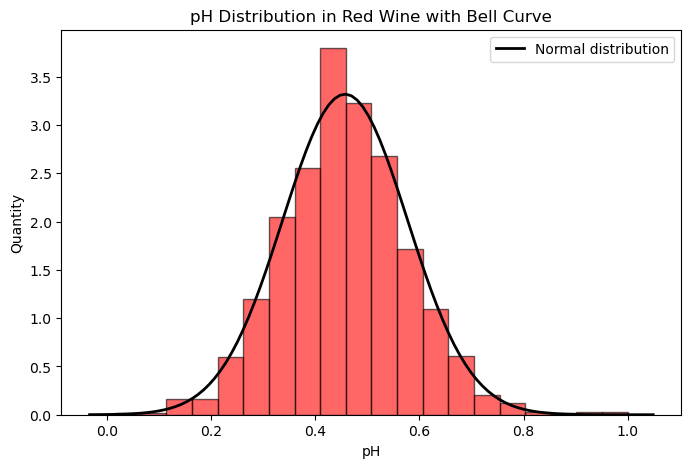

In [38]:
# Select red wine ph column
red_ph = red_wine_norm["pH"]

# Calculate mean and std for normal curve
mu, sigma = red_ph.mean(), red_ph.std()

# Plot histogram
plt.figure(figsize=(8,5))
count, bins, ignored = plt.hist(red_ph, bins=20, density=True,
                                color="red", edgecolor="black", alpha=0.6)

# Plot bell curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, "k", linewidth=2, label="Normal distribution")

plt.title("pH Distribution in Red Wine with Bell Curve")
plt.xlabel("pH")
plt.ylabel("Quantity")
plt.legend()
plt.show()

In [65]:
print(f"Mode: {red_ph.mode()}")
print(f"Mean: {red_ph.mean()}")

Mode: 0    0.449612
Name: pH, dtype: float64
Mean: 0.4571989207750795


## Findings in relation to the bell curve for pH value in red wine
There is a very small amount of positive skewing as is shown on the figure above, as there are larger portion of the dataset with a little bit lower pH value than the mode.
The mode for normalized pH value in red wine is 0.449, but the mean is 0.457, which means it is positively skewed.

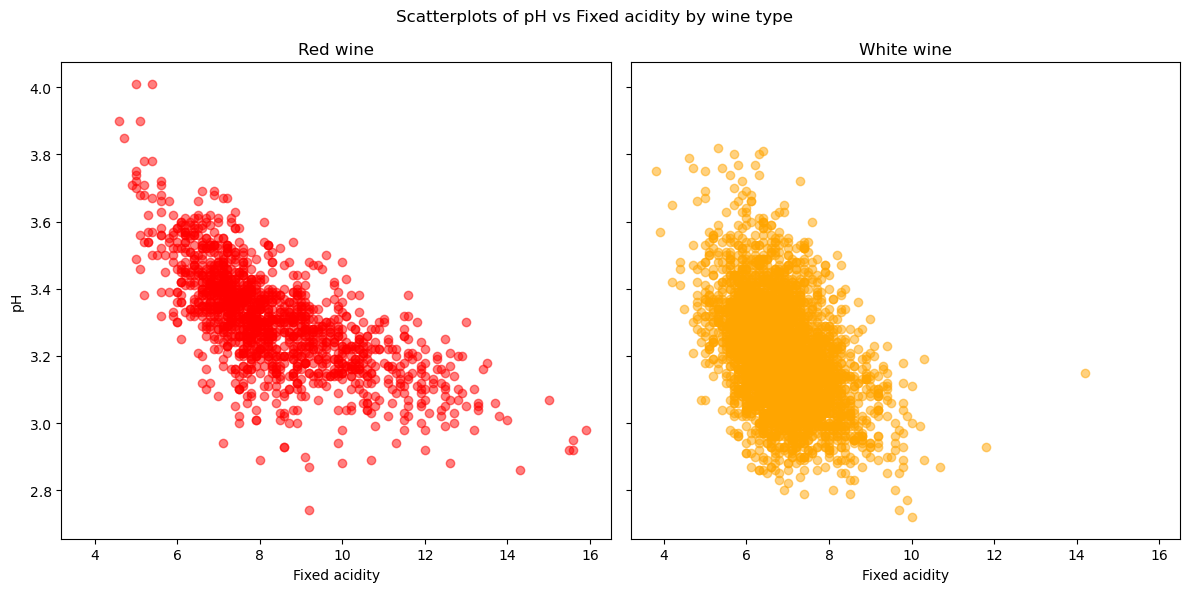

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)

# Red wine
axes[0].scatter(
    red_wine["fixed acidity"],
    red_wine["pH"],
    alpha=0.5,
    c="red"
)
axes[0].set_title("Red wine")
axes[0].set_xlabel("Fixed acidity")
axes[0].set_ylabel("pH")

# White wine
axes[1].scatter(
    white_wine["fixed acidity"],
    white_wine["pH"],
    alpha=0.5,
    c="orange"
)
axes[1].set_title("White wine")
axes[1].set_xlabel("Fixed acidity")

fig.suptitle("Scatterplots of pH vs Fixed acidity by wine type")
plt.tight_layout()
plt.show()

### Scatterplot for fixed acidity and pH value

The range for fixed acidity in the two different types of wine is:
    red: 4.6 - 15.9
    white: 3.8 - 14.2
Which means that there generally is more fixed acid in a red wine than white wine. This is despite that the pH value generally is lower for white wine.

Typically the more acidity something has, the lower pH value it has, as a low pH value indicates something's acid level, but it also depends on other compenents in the wine. In our diagram above we can see that red wine typically have a higher level of fixed acidity, despite the level of pH value typically is lower. This is due to other components in the wine that interacts with the acid.

We can also observe from the diagram that white wine is more clustered together than red wine.

#### Red wine
On the left side, we can see that as the amount of fixed acidity increases, the pH value decreases, which correlates with the heatmap information and general workings pH value.

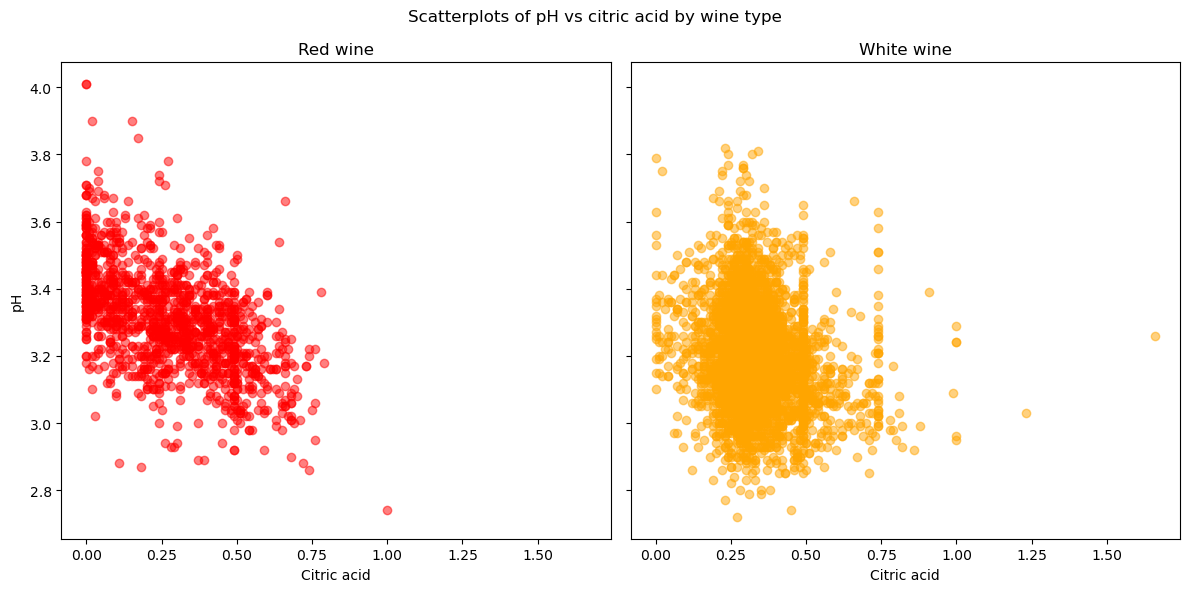

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)

# Red wine
axes[0].scatter(
    red_wine["citric acid"],
    red_wine["pH"],
    alpha=0.5,
    c="red"
)
axes[0].set_title("Red wine")
axes[0].set_xlabel("Citric acid")
axes[0].set_ylabel("pH")

# White wine
axes[1].scatter(
    white_wine["citric acid"],
    white_wine["pH"],
    alpha=0.5,
    c="orange"
)
axes[1].set_title("White wine")
axes[1].set_xlabel("Citric acid")

fig.suptitle("Scatterplots of pH vs citric acid by wine type")
plt.tight_layout()
plt.show()

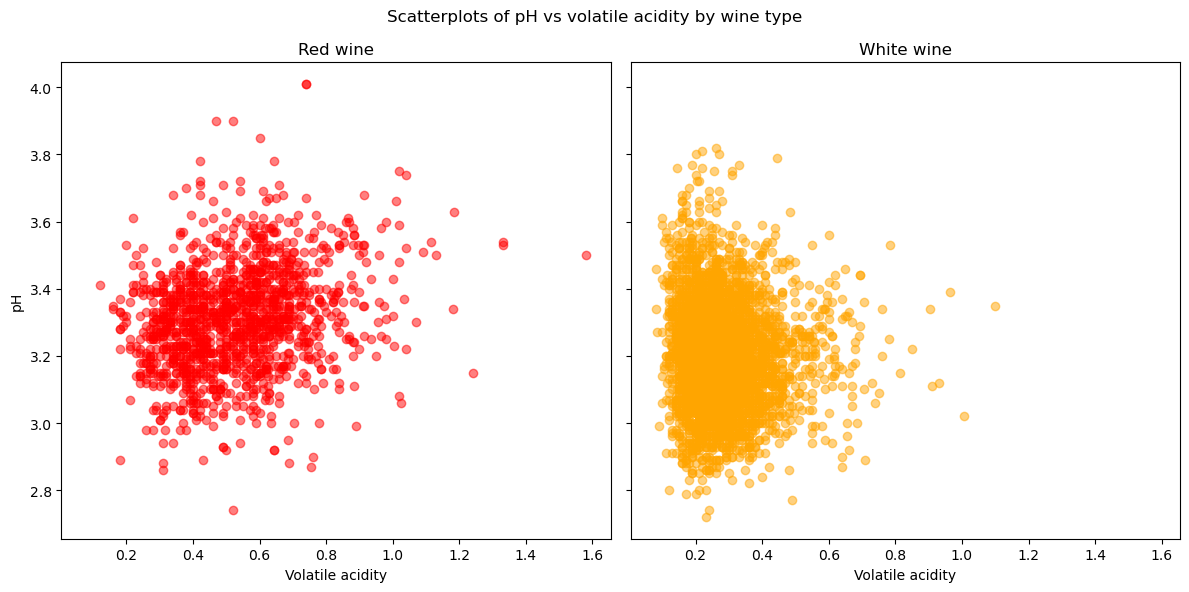

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)

# Red wine
axes[0].scatter(
    red_wine["volatile acidity"],
    red_wine["pH"],
    alpha=0.5,
    c="red"
)
axes[0].set_title("Red wine")
axes[0].set_xlabel("Volatile acidity")
axes[0].set_ylabel("pH")

# White wine
axes[1].scatter(
    white_wine["volatile acidity"],
    white_wine["pH"],
    alpha=0.5,
    c="orange"
)
axes[1].set_title("White wine")
axes[1].set_xlabel("Volatile acidity")

fig.suptitle("Scatterplots of pH vs volatile acidity by wine type")
plt.tight_layout()
plt.show()

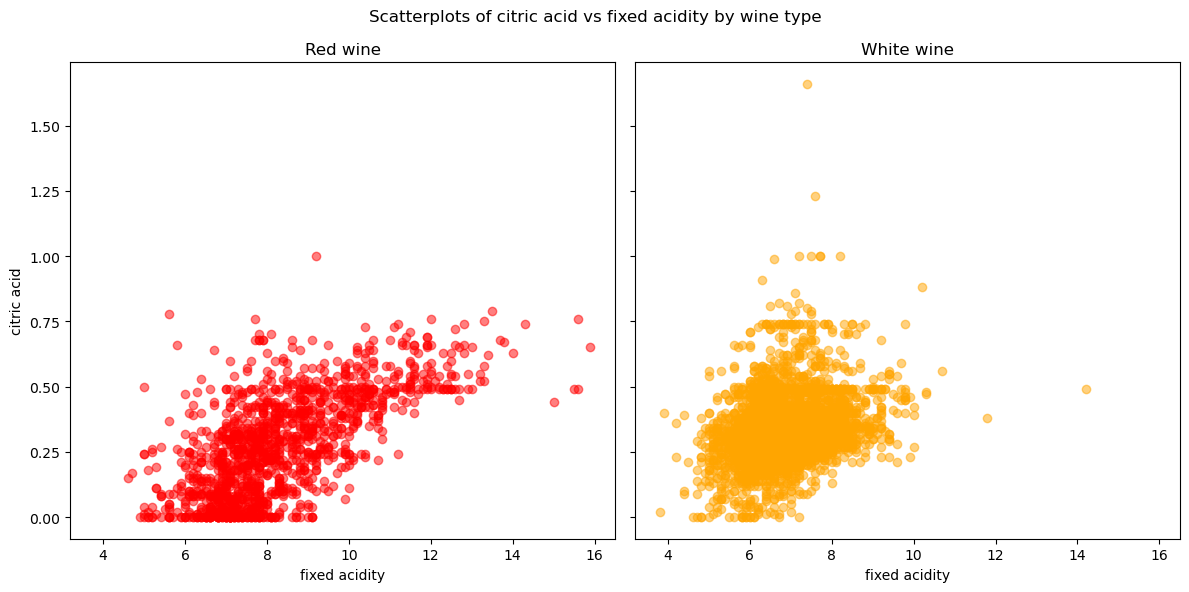

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)

# Red wine
axes[0].scatter(
    red_wine["fixed acidity"],
    red_wine["citric acid"],
    alpha=0.5,
    c="red"
)
axes[0].set_title("Red wine")
axes[0].set_xlabel("fixed acidity")
axes[0].set_ylabel("citric acid")

# White wine
axes[1].scatter(
    white_wine["fixed acidity"],
    white_wine["citric acid"],
    alpha=0.5,
    c="orange"
)
axes[1].set_title("White wine")
axes[1].set_xlabel("fixed acidity")

fig.suptitle("Scatterplots of citric acid vs fixed acidity by wine type")
plt.tight_layout()
plt.show()

## Findings in regards to acids and pH values in wine
the pH value measures whether something is primarily acidic or basic. Which is why one could assume all acids influence the pH value. However in the heat maps we can see that the volatile acid has a very low correlation to the pH value, but fixed acid is much higher correlated with pH value than volatile, and the citric acid is in between. 

In reards to the two different types of wine, we can see a much lower correlation bvetween the acids and pH value for white wine than red wine. We have decided to investigate it further as it interests us. 

First it is important to distinguish between the different types of acid, as they are very different in abilities and quantities.

### Fixed acid 
Fixed acid is one of the main determinants for the pH value in wine, as it releases the H+ ion, which is what the pH value measures in terms of acidity. Fixed acid is the part of the wine that gives it the tartness and mouthfeel of the wine. So in regards to the heat map it makes sense that it correlates, but as there are other components to wine than just fixed acid, it also makes sense that it is not a complete match, as there are other things that influence the pH value. 

### Volatile acid
Volatile acid is acids that can vaporize and is the by-product of microbial metabolism. When the fermantation happens in wine, the citric acid acts with microbes and is turned into volatile acid. The amount that is generally created in wine is extremely low and therefor does not influence the pH value. If there is a high concentration of volatile acid, it can be an indicator of a spoiled wine, and can make it taste like vinegar, as it is one of the main components of vinegar. Due to the low amounts of volatile acid generally found in wine per liter, it does not release enough ions to affect the pH value, so the low correlation to the heatmap does make sense. 

### Citric acid
Citric acid is a type of fixed acid. It is naturally occurent in many citrus fruits. It is used in wine making to give it a fruity tartness to the taste. As citric acid is a fixed acid, one can extrapolate that the pH value that is calculated from fixed acid includes the value from citric acid, and therefore it we can conclude that the correlation should be and is, bigger for fixed acid than citric acid, as it has 
a larger quantity in the wine. 

### Heatmap
In regards to the three types of acids we can therefore conclude that the correlation between volatile acid and pH value, should be lower than both citric acid and fixed acidity, as the quantity of volatile acid is too low to have an impact on the pH value.
Furthermore, the citric acid and pH value should have a lower correlation than the fixed acidity and pH value, as the citric acid is a part of the fixed acidity, but not all of it, and therefore there is a larger quantity of fixed acid to correlate with the pH value.

# Plot diagrams

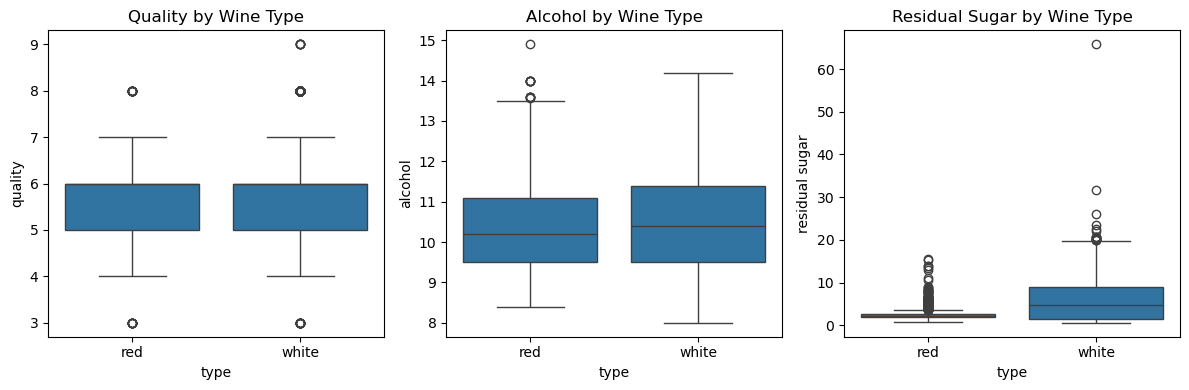

In [43]:
# a. Boxplots for at sammenligne fordelingen af quality, alcohol og residual sugar
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sb.boxplot(x="type", y="quality", data=wine)
plt.title("Quality by Wine Type")
plt.subplot(1,3,2)
sb.boxplot(x="type", y="alcohol", data=wine)
plt.title("Alcohol by Wine Type")
plt.subplot(1,3,3)
sb.boxplot(x="type", y="residual sugar", data=wine)
plt.title("Residual Sugar by Wine Type")
plt.tight_layout()
plt.show()

In [44]:
# which type of wine has higher average quality, how big is the difference?
mean_quality = wine.groupby("type")["quality"].mean()
print("average quality:\n", mean_quality)
print("difference:", abs(mean_quality["white"] - mean_quality["red"]))

# white has on average higher quality

average quality:
 type
red      5.623252
white    5.854835
Name: quality, dtype: float64
difference: 0.2315822462534367


C:\Users\rfwma\AppData\Local\Temp\ipykernel_24424\2172461371.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_quality = wine.groupby("type")["quality"].mean()


In [45]:
# which type of wine has higher average level of alcohol?
mean_alcohol = wine.groupby("type")["alcohol"].mean()
print("Average alcohol:\n", mean_alcohol)
print("difference:", abs(mean_alcohol["white"] - mean_alcohol["red"]))

# white has on average higher level of alcohol

Average alcohol:
 type
red      10.432315
white    10.589358
Name: alcohol, dtype: float64
difference: 0.15704247824183604


C:\Users\rfwma\AppData\Local\Temp\ipykernel_24424\1182970469.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_alcohol = wine.groupby("type")["alcohol"].mean()


In [46]:
# which one has higher average quantity of residual sugar?

mean_sugar = wine.groupby("type")["residual sugar"].mean()
print("Average residual sugar:\n", mean_sugar)
print("difference:", abs(mean_sugar["white"] - mean_sugar["red"]))

# white has on average higher quantity of residual sugar

Average residual sugar:
 type
red      2.523400
white    5.914819
Name: residual sugar, dtype: float64
difference: 3.3914199315288736


C:\Users\rfwma\AppData\Local\Temp\ipykernel_24424\3742301362.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_sugar = wine.groupby("type")["residual sugar"].mean()


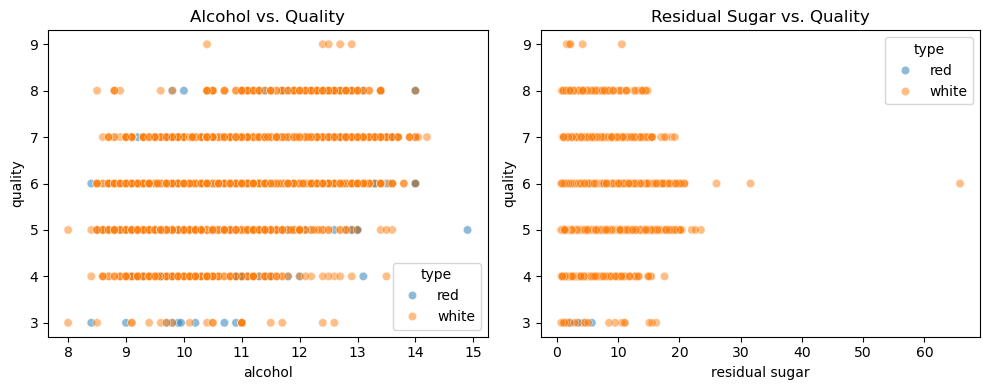

In [47]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sb.scatterplot(x="alcohol", y="quality", hue="type", data=wine, alpha=0.5)
plt.title("Alcohol vs. Quality")
plt.subplot(1,2,2)
sb.scatterplot(x="residual sugar", y="quality", hue="type", data=wine, alpha=0.5)
plt.title("Residual Sugar vs. Quality")
plt.tight_layout()
plt.show()

In [48]:
print("Korrelationskoefficient (alcohol vs. quality):")
print(wine[["alcohol", "quality"]].corr())
print("Korrelationskoefficient (residual sugar vs. quality):")
print(wine[["residual sugar", "quality"]].corr())

Korrelationskoefficient (alcohol vs. quality):
          alcohol   quality
alcohol  1.000000  0.469422
quality  0.469422  1.000000
Korrelationskoefficient (residual sugar vs. quality):
                residual sugar  quality
residual sugar         1.00000 -0.05683
quality               -0.05683  1.00000


In [49]:
#Binning wines in groups of 5 and 10 bins.

def find_highest_density(df, bins, label):
    #Bin the pH column
    binned = pd.cut(df["pH"], bins=bins)
    
    counts = binned.value_counts().sort_index()
    
    #Print the densest bin.
    max_bin = counts.idxmax()
    print(f"{label}: Number of bins = {bins} Highest density in pH range of {max_bin} with {counts.max()} samples")
    return counts

print("5 bins")
find_highest_density(wine, bins=5, label="All wines")
find_highest_density(wine[wine["type_encoded"]==0], bins=5, label="Red wines")
find_highest_density(wine[wine["type_encoded"]==1], bins=5, label="White wines")

print("\n10 bins")
find_highest_density(wine, bins=10, label="All wines")
find_highest_density(wine[wine["type_encoded"]==0], bins=10, label="Red wines")
find_highest_density(wine[wine["type_encoded"]==1], bins=10, label="White wines")

5 bins
All wines: Number of bins = 5 Highest density in pH range of (2.978, 3.236] with 2687 samples
Red wines: Number of bins = 5 Highest density in pH range of (3.248, 3.502] with 764 samples
White wines: Number of bins = 5 Highest density in pH range of (3.16, 3.38] with 1765 samples

10 bins
All wines: Number of bins = 10 Highest density in pH range of (3.107, 3.236] with 1718 samples
Red wines: Number of bins = 10 Highest density in pH range of (3.248, 3.375] with 470 samples
White wines: Number of bins = 10 Highest density in pH range of (3.05, 3.16] with 1116 samples


pH
(2.719, 2.83]      12
(2.83, 2.94]      131
(2.94, 3.05]      521
(3.05, 3.16]     1116
(3.16, 3.27]     1095
(3.27, 3.38]      670
(3.38, 3.49]      260
(3.49, 3.6]       113
(3.6, 3.71]        28
(3.71, 3.82]       15
Name: count, dtype: int64

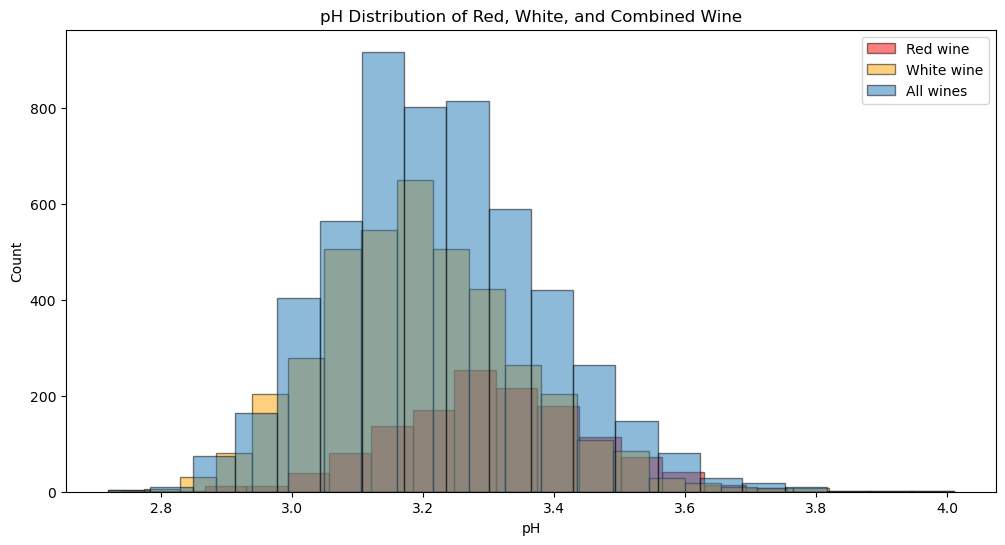

In [50]:
#Visual graph for pH density on red, white and all wines combined.
plt.figure(figsize=(12,6))

#Change bins=x the higer x is the more detailed the graph gets.
plt.hist(wine[wine["type_encoded"]==0]["pH"], bins=20, alpha=0.5, label="Red wine", edgecolor="black", color="red")
plt.hist(wine[wine["type_encoded"]==1]["pH"], bins=20, alpha=0.5, label="White wine", edgecolor="black", color="orange")
plt.hist(wine["pH"], bins=20, alpha=0.5, label="All wines", edgecolor="black")

plt.xlabel("pH")
plt.ylabel("Count")
plt.title("pH Distribution of Red, White, and Combined Wine")
plt.legend()
plt.show()

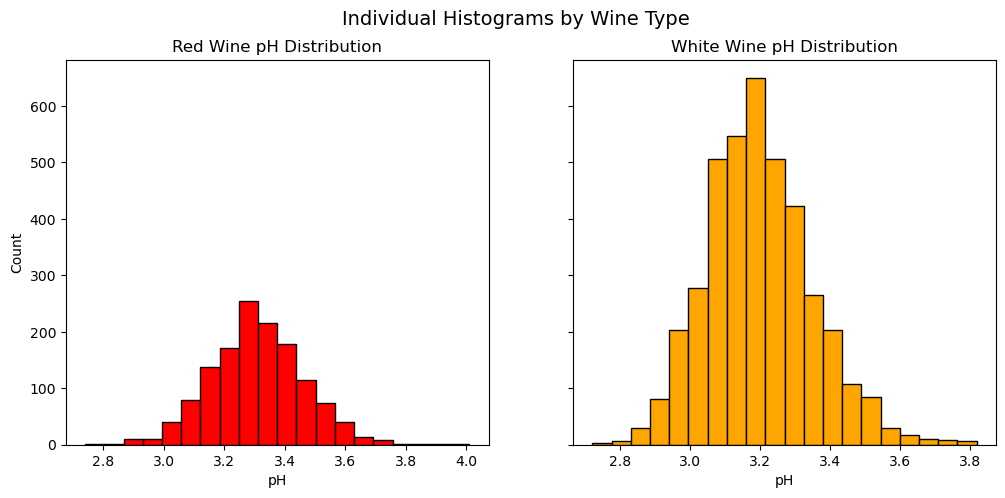

In [51]:
#Individual graphs for red and white wines.
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

axes[0].hist(wine[wine["type_encoded"]==0]["pH"], bins=20, color="red", edgecolor="black")
axes[0].set_title("Red Wine pH Distribution")
axes[0].set_xlabel("pH")
axes[0].set_ylabel("Count")

axes[1].hist(wine[wine["type_encoded"]==1]["pH"], bins=20, color="orange", edgecolor="black")
axes[1].set_title("White Wine pH Distribution")
axes[1].set_xlabel("pH")

plt.suptitle("Individual Histograms by Wine Type", fontsize=14)
plt.show()

C:\Users\rfwma\AppData\Local\Temp\ipykernel_24424\2959171248.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = wine.groupby(["pH_category", "type_encoded"]).size().unstack(fill_value=0)


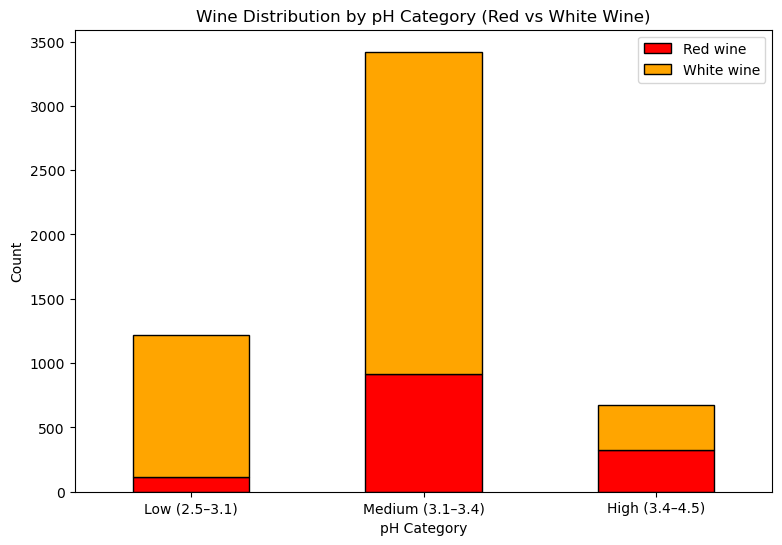

In [52]:
#Define bins and labels
bins = [2.5, 3.1, 3.4, 4.5]  
labels = ["Low", "Medium", "High"]

wine["pH_category"] = pd.cut(wine["pH"], bins=bins, labels=labels)

category_counts = wine.groupby(["pH_category", "type_encoded"]).size().unstack(fill_value=0)
category_counts.columns = ["Red wine", "White wine"]

range_labels = [
    f"Low ({bins[0]}–{bins[1]})",
    f"Medium ({bins[1]}–{bins[2]})",
    f"High ({bins[2]}–{bins[3]})"
]

ax = category_counts.plot(
    kind="bar", 
    stacked=True, 
    color=["red", "orange"], 
    edgecolor="black",
    figsize=(9,6)
)

ax.set_xlabel("pH Category")
ax.set_ylabel("Count")
ax.set_title("Wine Distribution by pH Category (Red vs White Wine)")
ax.set_xticklabels(range_labels, rotation=0)
plt.legend()
plt.show()